# summary 
code for predicing and evaluating across half resolution orthomosaic 

This code mirrors 03_evaluation_and_optimization and uses the same parameters and test set
The main differences are imput and output files and tile size

In [1]:
#imports 
import os
import fiftyone as fo
from sahi import AutoDetectionModel
from sahi.predict import get_sliced_prediction
from PIL import Image 
import os
from fiftyone import ViewField as F
import scipy


# first check the wd is not notebooks but the main folder
print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())


cwd is /home/tmueller/github/AIggregation/notebooks
cwd changed to /home/tmueller/github/AIggregation


 100% |█████████████████████| 1/1 [10.9ms elapsed, 0s remaining, 107.2 samples/s] 


04/10/2025 09:14:54 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [10.9ms elapsed, 0s remaining, 107.2 samples/s] 
/home/tmueller/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


 100% |█████████████████████| 1/1 [1.5m elapsed, 0s remaining, 0.0 samples/s] 


04/10/2025 09:16:25 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [1.5m elapsed, 0s remaining, 0.0 samples/s] 


Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port


04/10/2025 09:16:25 - INFO - fiftyone.core.service -   Connected to FiftyOne on port 5151 at localhost.
If you are not connecting to a remote session, you may need to start a new session and specify a port



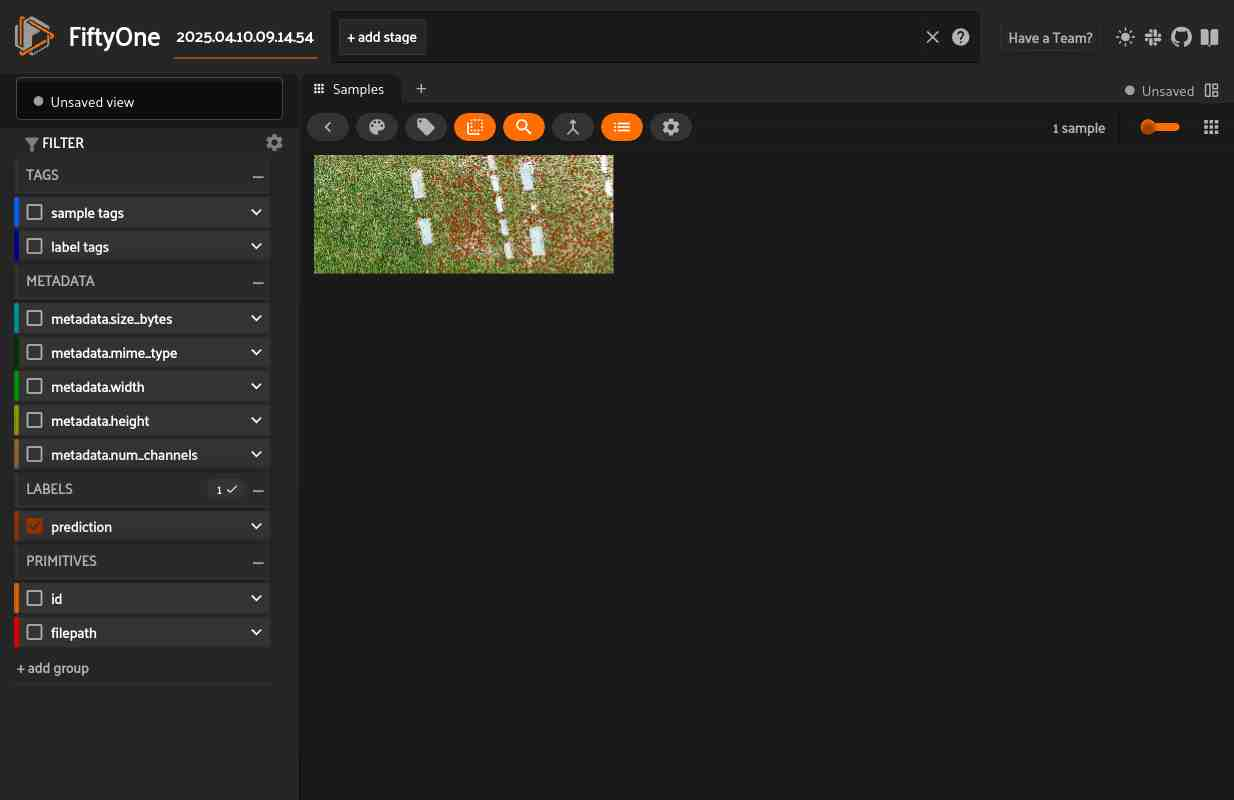

Directory 'datasets/export_predictions/temp_lowres' already exists; export will be merged with existing files


04/10/2025 09:16:26 - WARNING - fiftyone.core.collections -   Directory 'datasets/export_predictions/temp_lowres' already exists; export will be merged with existing files


 100% |█████████████████████| 1/1 [798.0ms elapsed, 0s remaining, 1.3 samples/s] 


04/10/2025 09:16:26 - INFO - eta.core.utils -    100% |█████████████████████| 1/1 [798.0ms elapsed, 0s remaining, 1.3 samples/s] 


In [2]:
# set paths
# -------------------------------------------------------------------------------------------------------------------- #
image_directory = "datasets/drone_ortho/low_res/ortho_clip_23april.png"     # path to image to be predicted on
model_path = "AIggregation_yolov5m/weights/best.pt"                      # path to image detection model
predictions_directory = "datasets/export_predictions/temp_lowres"                    # directory to export model predictions to
# --------------------------------------------------------------------- ----------------------------------------------- #



# Import ortho image into a fiftyone dataset 
dataset_full = fo.Dataset.from_images(
    [image_directory]
)

# specify AI detection model to use for predictions
detection_model = AutoDetectionModel.from_pretrained(
    model_type='yolov5',
    model_path=model_path, #specify path to trained model
    confidence_threshold=0.25,
    device="cuda", # "cpu" or "cuda" for GPU
)

# define function for sliced predictions from sahi
def predict_with_slicing(sample, label_field, **kwargs):
    result = get_sliced_prediction(
        sample.filepath, detection_model, verbose=0, **kwargs
    )
    sample[label_field] = fo.Detections(detections=result.to_fiftyone_detections())

# predict on image, slicing at training image size
for sample in dataset_full.iter_samples(progress=True, autosave=True):
    predict_with_slicing(sample,
                         label_field="prediction",
                         slice_height=304, 
                         slice_width=304,
                         overlap_height_ratio = .4, 
                         overlap_width_ratio=.4
    )


#launch fiftyone session to see predictions
session = fo.launch_app(dataset_full)


#export predictions
dataset_full.export(
        export_dir=predictions_directory,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="prediction",
        include_confidence=True
    )

# Importing image, predicting, and export 
# for half resolution dataset it took 37.3 seconds using GPU
# 64 gb DDR4-3200 ram




In [8]:

# set parameters for tiling script. to match ground truth tiles, set tile size to half
# -------------------------------------------------------------------------------------------------------------------- #
source_path = predictions_directory                              # directory where model prediction exported to
target_path = "./datasets/testset/tiled_testset_lowres"       # directory to save tiled testset
img_ext = ".png"                                            # type of image predicted on
tile_size = 304                                             # size of tiles in pixels. default 608
all_images = "TRUE"                                         # set to FALSE to only keep images with detections
test_ratio = 0.4                                            # proportion of tiles to keep for testset
overwrite = "FALSE"                                         # set to TRUE to create new testlist. default to pulling from existing list in one folder up from target
# -------------------------------------------------------------------------------------------------------------------- #


# set max image pixels to none
# otherwise pillow thinks large images might be a bomb DOS attack 
Image.MAX_IMAGE_PIXELS = None


# run riling script using above parameters
%run scripts/yolo_tile_modified.py -source {source_path} -target {target_path} -ext {img_ext}  -size {tile_size} -ratio {test_ratio} -overwrite {overwrite} -all_images {all_images}



Image: datasets/export_predictions/temp_lowres/images/val/ortho_clip_23april.png
[(0, <POLYGON ((12008.18 4098.24, 12064.884 4098.24, 12064.884 4152.984, 12008.18...>, 0.98223), (0, <POLYGON ((11905.416 528.992, 11963.419 528.992, 11963.419 586.631, 11905.41...>, 0.981032), (0, <POLYGON ((13249.755 4821.877, 13306.051 4821.877, 13306.051 4879.007, 13249...>, 0.98103), (0, <POLYGON ((13936.899 1932.693, 13992.831 1932.693, 13992.831 1991.868, 13936...>, 0.980864), (0, <POLYGON ((11742.919 508.718, 11790.329 508.718, 11790.329 557.497, 11742.91...>, 0.980835), (0, <POLYGON ((12397.582 5215.107, 12458.402 5215.107, 12458.402 5278.637, 12397...>, 0.979594), (0, <POLYGON ((11320.364 905.111, 11375.303 905.111, 11375.303 962.94, 11320.364...>, 0.979551), (0, <POLYGON ((4451.859 3913.555, 4508.855 3913.555, 4508.855 3970.905, 4451.859...>, 0.979546), (0, <POLYGON ((9460.927 5631.843, 9514.451 5631.843, 9514.451 5687.697, 9460.927...>, 0.979534), (0, <POLYGON ((9248.162 4243.896, 9308.339 4243

Now validate the low resolution

In [3]:
# set paths for validation
# -------------------------------------------------------------------------------------------------------------------- #
gt_directory = "datasets/testset/groundtruth_testset"       # Directory with labelstudio groundtruth export extracted. Should contain "images" and "labels" folders
tiled_test_directory = "datasets/testset/tiled_testset_lowres"     # target folder for tile script ("target_path" in previous notebook)
# -------------------------------------------------------------------------------------------------------------------- #



# import test tiles into fiftyone
datasettest = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(tiled_test_directory, "dataset.yaml"),
    label_field= "prediction"
)

# import groundtruthed tiles into fiftyone
dataset_ground = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(gt_directory,"dataset.yaml"),
    label_field= "ground_truth"
)

# merge the datasets, merging images/labels with the same file name
key_fcn = lambda sample: os.path.basename(sample.filepath)

datasettest.merge_samples(dataset_ground, key_fcn=key_fcn)



# delete any oblong box predictions
# these are created by splitting tiles through the middle of an existing bounding box. Nest predictions should not be oblong

# Compute the dimensions of each bounding box in pixels
box_width, box_height = F("bounding_box")[2], F("bounding_box")[3]

# remove detections where one side of the box is greater than 2.5 time the other
def get_label_fields(sample_collection):
    """Get the (detection) label fields of a Dataset or DatasetView."""
    label_fields = list(
        sample_collection.get_field_schema(embedded_doc_type=fo.Detections).keys()
    )
    return label_fields


for lf in get_label_fields(datasettest):
    datasettest_temp = datasettest.filter_labels(
    "prediction", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False)


for lf in get_label_fields(datasettest_temp):
    datasettest_keep = datasettest_temp.filter_labels(
    "ground_truth", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False)




 100% |█████████████████| 216/216 [243.8ms elapsed, 0s remaining, 892.9 samples/s] 


04/10/2025 09:17:09 - INFO - eta.core.utils -    100% |█████████████████| 216/216 [243.8ms elapsed, 0s remaining, 892.9 samples/s] 


 100% |█████████████████| 365/365 [285.9ms elapsed, 0s remaining, 1.3K samples/s]     


04/10/2025 09:17:09 - INFO - eta.core.utils -    100% |█████████████████| 365/365 [285.9ms elapsed, 0s remaining, 1.3K samples/s]     


Indexing dataset...


04/10/2025 09:17:09 - INFO - fiftyone.core.dataset -   Indexing dataset...


 100% |█████████████████| 216/216 [101.7ms elapsed, 0s remaining, 2.1K samples/s] 


04/10/2025 09:17:09 - INFO - eta.core.utils -    100% |█████████████████| 216/216 [101.7ms elapsed, 0s remaining, 2.1K samples/s] 


Merging samples...


04/10/2025 09:17:09 - INFO - fiftyone.core.dataset -   Merging samples...


 365 [644.0ms elapsed, ? remaining, 568.4 samples/s] 


04/10/2025 09:17:10 - INFO - eta.core.utils -    365 [644.0ms elapsed, ? remaining, 568.4 samples/s] 



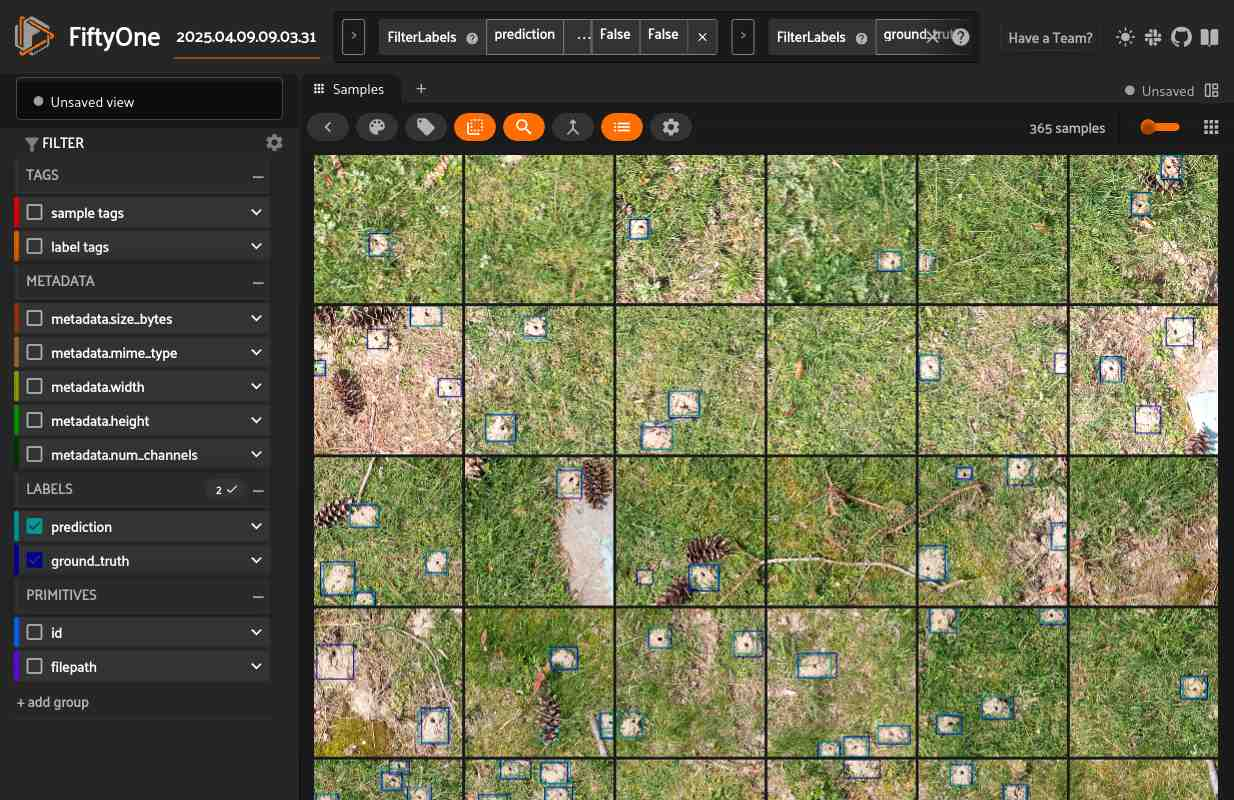

In [10]:

session = fo.launch_app(datasettest_keep)

In [ ]:
# set parameters
# -------------------------------------------------------------------------------------------------------------------- #
dataset = datasettest_keep      # filtered dataset 
prediction = "prediction"       # prediction name
gt = "ground_truth"             # ground truth name
lb = .1                         # lower confidence to check between
ub = .99                        # upper confidence to check between
iou = 0.4                       # what IOU to use for FN and FP detections
# -------------------------------------------------------------------------------------------------------------------- #



# define function to calculate the f1 score of a model
def calculate_f1(conf, dataset, prediction, gt):
    conf_view = dataset.filter_labels(prediction, F("confidence") >= conf)
    results = conf_view.evaluate_detections(prediction,
        gt_field= gt,
        eval_key="eval",
        missing="fn",
        iou = iou)

    fp = sum(conf_view.values("eval_fp"))
    tp = sum(conf_view.values("eval_tp"))
    fn = sum(conf_view.values("eval_fn"))

    f1 = tp/(tp+0.5*(fp+fn))

    return -1.0*f1  #make output negative to use fminbound in following function

calculate_f1(dataset=dataset, conf=.5, prediction=prediction, gt=gt)


# define function find the optimal output of the above function
def optimize_conf(lb, ub, dataset, gt, prediction):

    res = scipy.optimize.fminbound(
                    func=calculate_f1,
                    x1=lb,
                    x2=ub,
                    args=(dataset, prediction, gt),
                    xtol=0.01,
                    full_output=True
    )

    best_conf, f1val, ierr, numfunc = res
    maxf1 = -1.0*f1val
    print("\n \n     best f1          at confidence")
    print(maxf1, best_conf)
    return maxf1, best_conf


# save second output, best_conf, to a variable for use in filtering predictions
bestconf = optimize_conf(lb=lb, ub=ub, dataset=dataset, gt=gt, prediction=prediction)[1]


# filter and evaluate model performance at best conf threshold
high_f1_view = datasettest_keep.filter_labels("prediction", F("confidence") >= bestconf, only_matches=False)


results_f1 = high_f1_view.evaluate_detections(
    prediction,
    gt_field=gt,
    eval_key="prediction",
    missing = "fn",
    iou = iou,
    compute_mAP=True
)


def eval_model(conf, dataset, prediction, gt):
    conf_view = dataset.filter_labels(prediction, F("confidence") >= conf)
    results = conf_view.evaluate_detections(prediction,
        gt_field= gt,
        eval_key="eval",
        missing="fn",
        iou = iou)

    fp = sum(conf_view.values("eval_fp"))
    tp = sum(conf_view.values("eval_tp"))
    fn = sum(conf_view.values("eval_fn"))

    f1 = tp/(tp+0.5*(fp+fn))

    print("\n      f1                 precicion           recall")
    return f1, tp/(tp+fp), tp/(tp+fn) #make output negative to use fminbound in following function


print(eval_model(dataset=high_f1_view, conf=bestconf, prediction=prediction, gt=gt))

# print performance results
print("\n \n model mAP:", results_f1.mAP(), "\n \n")


session = fo.launch_app(high_f1_view)


Evaluating detections...


04/10/2025 09:17:22 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 188/188 [641.0ms elapsed, 0s remaining, 293.3 samples/s]      


04/10/2025 09:17:23 - INFO - eta.core.utils -    100% |█████████████████| 188/188 [641.0ms elapsed, 0s remaining, 293.3 samples/s]      


Evaluating detections...


04/10/2025 09:17:23 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 189/189 [794.1ms elapsed, 0s remaining, 238.0 samples/s]      


04/10/2025 09:17:24 - INFO - eta.core.utils -    100% |█████████████████| 189/189 [794.1ms elapsed, 0s remaining, 238.0 samples/s]      


Evaluating detections...


04/10/2025 09:17:24 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 186/186 [622.4ms elapsed, 0s remaining, 298.8 samples/s]      


04/10/2025 09:17:25 - INFO - eta.core.utils -    100% |█████████████████| 186/186 [622.4ms elapsed, 0s remaining, 298.8 samples/s]      


Evaluating detections...


04/10/2025 09:17:25 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 189/189 [631.6ms elapsed, 0s remaining, 299.2 samples/s]      


04/10/2025 09:17:26 - INFO - eta.core.utils -    100% |█████████████████| 189/189 [631.6ms elapsed, 0s remaining, 299.2 samples/s]      


Evaluating detections...


04/10/2025 09:17:26 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [650.6ms elapsed, 0s remaining, 292.0 samples/s]      


04/10/2025 09:17:27 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [650.6ms elapsed, 0s remaining, 292.0 samples/s]      


Evaluating detections...


04/10/2025 09:17:27 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [843.7ms elapsed, 0s remaining, 225.2 samples/s]      


04/10/2025 09:17:28 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [843.7ms elapsed, 0s remaining, 225.2 samples/s]      


Evaluating detections...


04/10/2025 09:17:28 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [637.8ms elapsed, 0s remaining, 297.9 samples/s]      


04/10/2025 09:17:28 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [637.8ms elapsed, 0s remaining, 297.9 samples/s]      


Evaluating detections...


04/10/2025 09:17:29 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [638.9ms elapsed, 0s remaining, 297.4 samples/s]      


04/10/2025 09:17:29 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [638.9ms elapsed, 0s remaining, 297.4 samples/s]      


Evaluating detections...


04/10/2025 09:17:29 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [848.5ms elapsed, 0s remaining, 223.9 samples/s]      


04/10/2025 09:17:30 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [848.5ms elapsed, 0s remaining, 223.9 samples/s]      


Evaluating detections...


04/10/2025 09:17:30 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [644.3ms elapsed, 0s remaining, 294.9 samples/s]      


04/10/2025 09:17:31 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [644.3ms elapsed, 0s remaining, 294.9 samples/s]      


Evaluating detections...


04/10/2025 09:17:31 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [639.7ms elapsed, 0s remaining, 297.0 samples/s]      


04/10/2025 09:17:32 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [639.7ms elapsed, 0s remaining, 297.0 samples/s]      


Evaluating detections...


04/10/2025 09:17:32 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [644.0ms elapsed, 0s remaining, 295.0 samples/s]      


04/10/2025 09:17:33 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [644.0ms elapsed, 0s remaining, 295.0 samples/s]      



 
     best f1          at confidence
0.9029443838604144 0.26317873598666486
Evaluating detections...


04/10/2025 09:17:33 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 365/365 [997.2ms elapsed, 0s remaining, 366.0 samples/s]      


04/10/2025 09:17:34 - INFO - eta.core.utils -    100% |█████████████████| 365/365 [997.2ms elapsed, 0s remaining, 366.0 samples/s]      


Performing IoU sweep...


04/10/2025 09:17:34 - INFO - fiftyone.utils.eval.coco -   Performing IoU sweep...


 100% |█████████████████| 365/365 [847.5ms elapsed, 0s remaining, 430.7 samples/s]      


04/10/2025 09:17:35 - INFO - eta.core.utils -    100% |█████████████████| 365/365 [847.5ms elapsed, 0s remaining, 430.7 samples/s]      


Evaluating detections...


04/10/2025 09:17:35 - INFO - fiftyone.utils.eval.detection -   Evaluating detections...


 100% |█████████████████| 190/190 [774.8ms elapsed, 0s remaining, 245.2 samples/s]      


04/10/2025 09:17:36 - INFO - eta.core.utils -    100% |█████████████████| 190/190 [774.8ms elapsed, 0s remaining, 245.2 samples/s]      



      f1                 precicion           recall
(0.9029443838604144, 0.9695550351288056, 0.8448979591836735)

 
 model mAP: 0.42208175868910847 
 

